# overall workflow

## data acquisition
We scrape data from Tagesspiegel, a Berlin based newspaper covering local, national and international topics.

In [256]:
from datetime import date
from data_acquisition import scrape_tsp as st

In [257]:
str(date.today())

'2020-09-07'

In [258]:
st.get_links()

<Response [200]>


'wrote 158 links to data_acquisition/links-tsp-2020-09-07.txt'

In [259]:
scraped_file = 'data_acquisition/links-tsp-' + str(date.today()) + '.txt'
st.select_new_links(scraped_file)

Before running the next cell, update the integer number in st.get_content( .. , int , ...)

Should be updated to the numer that was returned the last time the cell ran.

In [260]:
#%run 'data-acquisition/get-content-02.py'
#from data_acquisition import get_content_tsp_03

import os

path_to_link_file= 'data_acquisition/links-tsp-'+str(date.today())+'-new.txt'
path_to_output_folder='tagesspiegel-'+str(date.today())

_, dirs, _ = next(os.walk(os.getcwd()))

if path_to_output_folder in dirs:
    print("** folder exists **")
else:
    os.mkdir(path_to_output_folder, mode=0o744) 

#print(path_to_output_folder)
st.get_content(path_to_link_file,1257,path_to_output_folder)

1382

When articles are downloaded, add new links to 'bestand'
in unix: cat file_with_new_links >> bestands_file

In [ ]:
# use cat in unix or copy paste by hand

## data cleaning
 1. We check for advertisement in the articles' text. Ad text is included in brackets [...]
 2. We check for empty authors. 
 3. We check for missing date of publication
 4. We check for press releases
 5. remove content from plus.tagesspiegel.de (advertising, infotainment, Kundenbindung)
 
ad 2: An empty list of authors is replaced by the name of the paper: Tagesspiegel.

ad 4: An article that is a press release has closing characters (tsp) or (tsp,dpa) or similar. We remove the parenthesis and the enclosed text.

In [7]:
from data_cleaning import clean_tsp_02 as ct

In [261]:
ct.clean_up('tagesspiegel-2020-09-07','2020-09-07')

tagesspiegel-2020-09-07/01337.json
tagesspiegel-2020-09-07/01288.json


{'files inspected': 123,
 'files with ads': 65,
 'ads removed': 80,
 'files removed': 2,
 'files removed reasons': ['too short', 'wrong type: imagegallery'],
 'dates imputed': 5}

In [5]:
ct.clean_up('tagesspiegel-2020-08-02','2020-08-02')

tagesspiegel-2020-08-02/00843.json
tagesspiegel-2020-08-02/00859.json
tagesspiegel-2020-08-02/00878.json
tagesspiegel-2020-08-02/00840.json


{'files inspected': 78,
 'files with ads': 43,
 'ads removed': 64,
 'files removed': 4,
 'files removed reasons': ['wrong type: author',
  'wrong type: imagegallery',
  'too short',
  'too short'],
 'dates imputed': 6}

In [3]:
ct.clean_up('tagesspiegel-2020-09-04','2020-09-04')

tagesspiegel-2020-09-04/01126.json
tagesspiegel-2020-09-04/01045.json
tagesspiegel-2020-09-04/01048.json


{'files inspected': 138,
 'files with ads': 61,
 'ads removed': 81,
 'files removed': 3,
 'files removed reasons': ['wrong type: imagegallery',
  'wrong type: imagegallery',
  'wrong type: imagegallery'],
 'dates imputed': 9}

In [4]:
ct.clean_up('tagesspiegel-2020-08-04','2020-08-04')

tagesspiegel-2020-08-04/00973.json
tagesspiegel-2020-08-04/01016.json
tagesspiegel-2020-08-04/00914.json


{'files inspected': 118,
 'files with ads': 60,
 'ads removed': 74,
 'files removed': 3,
 'files removed reasons': ['too short',
  'wrong type: imagegallery',
  'too short'],
 'dates imputed': 6}

In [8]:
ct.clean_up('tagesspiegel-2020-09-05','2020-09-05')

tagesspiegel-2020-09-05/01239.json


{'files inspected': 89,
 'files with ads': 40,
 'ads removed': 51,
 'files removed': 1,
 'files removed reasons': ['too short'],
 'dates imputed': 7}

## ml task

In [20]:
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

import re

from textblob_de import TextBlobDE 

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math

import json


def preprocessing_02 (text):
    #print(text)
    a = text.lower() # lower cases only
    b = re.sub("(\\W|\\d)"," ",a) #remove non-ascii and digits
    blob = TextBlobDE(b)
    return(blob.words.lemmatize()) # lemmatize for german


def read_articles_transform_to_df (path_to_text_files='../tagesspiegel/*.txt'):

	file_list=glob.glob(path_to_text_files)
	#file_list = glob.glob("../tagesspiegel/*.txt")
	#print(file_list)

	n = len(file_list)
	print(n , "files to work with.")

	#list_of_articles = []
	X = pd.DataFrame(columns=['file','text'])

	for i in range(n):
		#print(i, ' of ', n)
		with open (file_list[i]) as file:
			text_1 = file.read()
			text_2 = json.loads(text_1)
			text_3 = text_2['text']
			text=' '.join(preprocessing_02(text_3))
			#print(text)
			X=X.append({'file':file_list[i] , 'text':text}, ignore_index=True)
	#print(X.shape)
	return(X)

def enthropy(pv):

	# should check, that all values are positive and sum to (about) 1
	return(-sum([pv[i]*math.log(pv[i]) for i in range(len(pv))]))

def evaluate_cluster(km_object):
	n, bins, patches = plt.hist(km_object.labels_, km_object.n_clusters, facecolor='blue', alpha=0.5)
	plt.title('sizes of clusters')
	plt.ylabel('nr. of articles')
	plt.show()

	rel_fq = [round(ni/sum(n),3) for ni in n] 
#		print('elements in bins: ' , n)
#		print('relative size of bins: ', rel_fq)
#		print('enthropy: ', enthropy(rel_fq))

	return({'n': n , 'frequencies': rel_fq , 'enthropy': enthropy(rel_fq), 'inertia':km_object.inertia_})

preprocessing does some basic transfomation of a text into a wordlist:

Remove non ascii symbols and numbers / digits.

Remove punctuation. Lemmatize.

In [3]:
preprocessing_02('Ich, meiner, mir, mich. Hallo hier ist ein Baum. %§/$. Oder 8 oder 9 oder 77 bzw. zwölf?? Läuft lief gelaufen')

WordList(['ich', 'meinern', 'mir', 'mich', 'hallo', 'hier', 'sein', 'ein', 'baum', 'oder', 'oder', 'oder', 'bzw', 'zwölf', 'laufen', 'laufen', 'laufen'])

In [21]:
X = read_articles_transform_to_df('tagesspiegel_01/*clean.json')
#X['text'][0] # to check what we work with: Umlaute are correct, Data cleaning should have removed advertising text ...

615 files to work with.
Empty DataFrame
Columns: [file, text]
Index: []
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
25

In [26]:
list_of_articles = X['text']

cv = TfidfVectorizer(max_df=0.8 , min_df =2)
#print('cv: ' , dir(cv))
km =  KMeans(init='k-means++', n_clusters=5, n_init=10)

text_cluster = Pipeline([('vect', cv), ('cluster', km) ])

#text_cluster.fit(list_of_articles[0:100])
text_cluster.fit(list_of_articles)

#labels_as_column = pd.DataFrame(km.labels_)
#print(type(labels_as_column), labels_as_column.shape)

X['cluster'] = pd.DataFrame(km.labels_) # contains labels
#print(X)

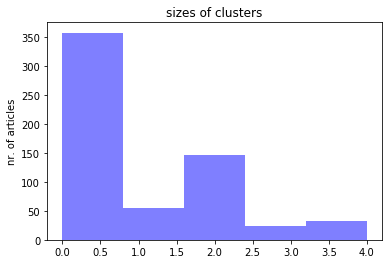

['aachener',
 'ab',
 'abbau',
 'abbauen',
 'abbiegen',
 'abbilden',
 'abbrechen',
 'abc',
 'abd',
 'abdankung']

In [27]:
evaluate_cluster(km)
cv.get_feature_names()[0:10]

How to represent a cluster? 
The centroid is a numerical vector, has to be translated back into words. But how?

In [28]:
centers = np.array(km.cluster_centers_)
print(centers.shape)


(5, 17310)


## Word cloud representation for single article

In [209]:
#!pip install wordcloud

In [29]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # don't need english STOPWORDS
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
text = [w for w in X['text'][2].split() if w in cv.get_feature_names()]
' '.join(text)

'er machen angst bange so er birol ünel kaputt barkeeper fatih akins liebesdrama gegen wand um kopf spielte er dies verloren menschen gerade so grenzen seines dabeien sprengte immer seinem namen verbinden birol ünel kommen fasen aus nichts vor jahren haute um film seine darsteller erhielt golden bären dafüren european film awards preise jen jahr fall lieb retten später fatih akins soul kitch spielte ünel koch er oft dies heftig unberechenbaren aggressiv typen gespielt gangster mut wild selten türkisch silifke gebären wuchs birol ünel nähe bremen studiert schauspiel hannover geben thomas passagier welcome to germany kz seite tony birol ünel cahit fatih akins gegen wand foto imago united neunzigern spielte er theater führen regie berliner kunsthaus tacheles treten bei frank castorf siegfried dess nibelungen born bad nochen so draufgänger passt heinrich tv er sehen man kannte ihn trotzdem kaum bis fatih akin ihm dies hauptrolle geben durchbruch später blieb meistens bei kino fernsehen bir

Some stopwords are features.

In [68]:
my_stopper = ['am','sie','bei','durch','noch','sich','in','im','ihr','ihre','vor','zur','seit','es','zu','werden','haben','sein','von','jedoch','auch','des','dies','als','wie','dem','den','um','mit','sein','auf','der','die','das','und','ein','aus','kein','wir','ihr','er','dass','du','ich','mein','mich','dein','dir','dich']
# [w in cv.get_feature_names() for w in my_stopper]

List comprehension to filter non-stopp-words.

In [50]:
text = [w for w in X['text'][4].split() if w not in my_stopper]
# [w in text for w in my_stopper] # test, shoulf result in only FALSE

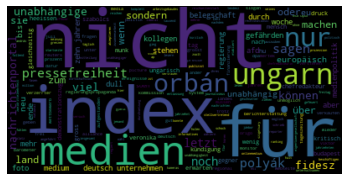

In [52]:
wordcloud = WordCloud().generate(' '.join(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# this is strange, there are words from my stoplist in the wordcloud.
# These words were never an argument to the wordcloud generation ?? !!

## Word cloud representation for cluster

Collect all text from a specified cluster and create its wordcloud.

In [116]:
K=km.n_clusters
for k in range(K):
#df.loc[df['column_name'] == some_value]
    Xcl = X.loc[X['cluster']==k]['text']
    print('size of cluster: ' , Xcl.shape)
    
    t1 = ''
    for i in Xcl:
        t1 += ' '.join([w for w in i.split() if w not in my_stopper])

    # remove stop words (again)
    text = [w for w in t1.split() if w not in my_stopper]
    wordcloud = WordCloud().generate(' '.join(text))
    wordcloud.to_file('cluster'+str(k)+'.png')

size of cluster:  (357,)
size of cluster:  (55,)
size of cluster:  (147,)
size of cluster:  (23,)
size of cluster:  (33,)


## presentation as html , website